In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data+other.data, (self, other), "+")
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        out = Value(self.data-other.data, (self, other), "-")
        return out

    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __div__(self, other):
        out = Value(self.data/other.data, (self, other), "/")
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1
        # build a topological order
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for c in v._prev:
                    build_topo(c)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()
         

In [97]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for c in v._prev:
                edges.add((c, v))
                build(c)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir":'LR'}) #LR - left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot


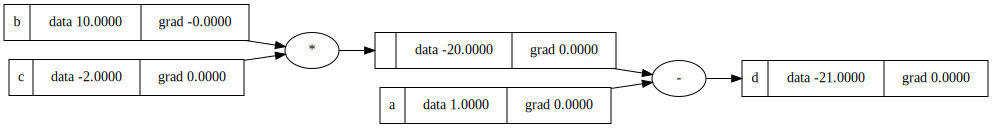

In [98]:
a = Value(1, label="a")
b = Value(10, label="b")
c = Value(-2, label="c")

d = b*c - a
d.label = "d"

draw_dot(d)

In [120]:
#Neuron example
#inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias
b = Value(6.7, label="b")

x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1w1x2w2"
n =  x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"

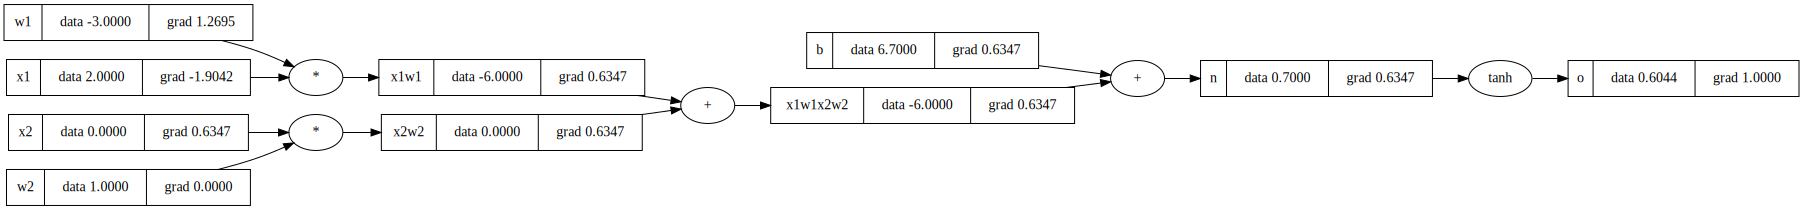

In [122]:
draw_dot(o)


In [89]:
#super manual
o.grad = 1
# o = tanh(n)
# do/dn = 1 - o^2
n.grad = 1-o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

In [106]:
o.grad = 1
o._backward()
n._backward()

In [108]:
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [111]:
o.grad = 1
# build a topological order
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for c in v._prev:
            build_topo(c)
        topo.append(v)
build_topo(o)

In [ ]:
for node in revered(topo):
    node._backward()

In [121]:
o.backward()